In [64]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, FuncFormatter
import os
import csv
import re

In [65]:
def get_files():
    base_dir = os.path.join(os.getcwd(), "scans")
    results = {}
    scan_degree = 0

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == "bathymetry.csv":
                folder_name = os.path.basename(root)
                sand_height = 0

                deg_match = re.search(r"_([0-9]+(?:\.[0-9]+)?)_deg", folder_name)
                sand_match = re.search(r"_([0-9]+(?:\.[0-9]+)?)_cm", folder_name)

                scan_degree = float(deg_match.group(1)) if deg_match else None
                sand_height = float(sand_match.group(1)) if sand_match else None

                depths = []
                timestamps = []
                with open(os.path.join(root, file), "r", newline="") as f:
                    reader = csv.reader(f)
                    for columns in reader:
                        depth = float(columns[2])
                        timestamp = float(columns[4])
                        depths.append(depth)
                        timestamps.append(timestamp)
                    f.close()

                if depths:
                    mean_bathy = np.mean(depths) * 100
                    std_dev = np.std(depths) * 100
                    std_dev_lower = std_dev * 0.9
                    std_dev_upper = std_dev * 1.15
                    results[sand_height] = (
                        mean_bathy,
                        depths,
                        timestamps,
                        std_dev_lower,
                        std_dev_upper,
                    )

    sorted_data = sorted(results.keys())
    avg_bathymetry_data = [results[h][0] for h in sorted_data]
    depths = [results[h][1] for h in sorted_data]
    timestamps = [results[h][2] for h in sorted_data]
    std_dev_lower = [results[h][3] for h in sorted_data]
    std_dev_upper = [results[h][4] for h in sorted_data]

    return sorted_data, scan_degree, avg_bathymetry_data, depths, timestamps, std_dev_lower, std_dev_upper


In [66]:
heights, scan_degree, avg_bathy_data, depths, timestamps, std_dev_lower, std_dev_upper = get_files()
expected_heights = np.array(heights)
observed_water_height = 69

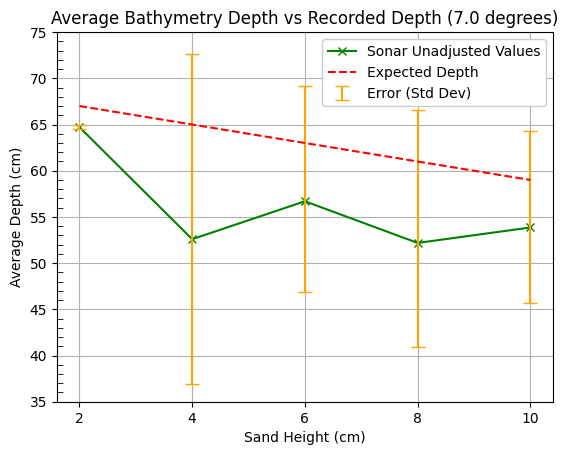

In [67]:
plt.plot(
    expected_heights,
    avg_bathy_data,
    marker="x",
    linestyle="-",
    color="green",
    label="Sonar Unadjusted Values",
)

plt.errorbar(
    expected_heights,
    avg_bathy_data,
    yerr=[std_dev_lower, std_dev_upper],
    fmt="none",
    ecolor="orange",
    capsize=5,
    label="Error (Std Dev)",
)

numeric_sand_heights = list(expected_heights)
dotted_line_y = [observed_water_height - height for height in numeric_sand_heights]
plt.plot(expected_heights, dotted_line_y, "r--", label="Expected Depth")

ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(1))
# ax.margins(x=0)
ax.tick_params(axis="y", which="minor", length=4, color="black", direction="in")
ax.set_ylim(35, 75)

plt.xlabel("Sand Height (cm)")
plt.ylabel("Average Depth (cm)")
plt.title(f"Average Bathymetry Depth vs Recorded Depth ({scan_degree} degrees)")
plt.grid(True)
plt.xticks(expected_heights)
plt.legend(framealpha=1.0)

plt.show()


In [68]:
def format_time(seconds, pos):
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    return f"{minutes:02d}:{sec:02d}"

In [69]:
expected_heights_label = []

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

for index, height in enumerate(expected_heights):
    expected_heights_label.append((observed_water_height - height, colors[index]))


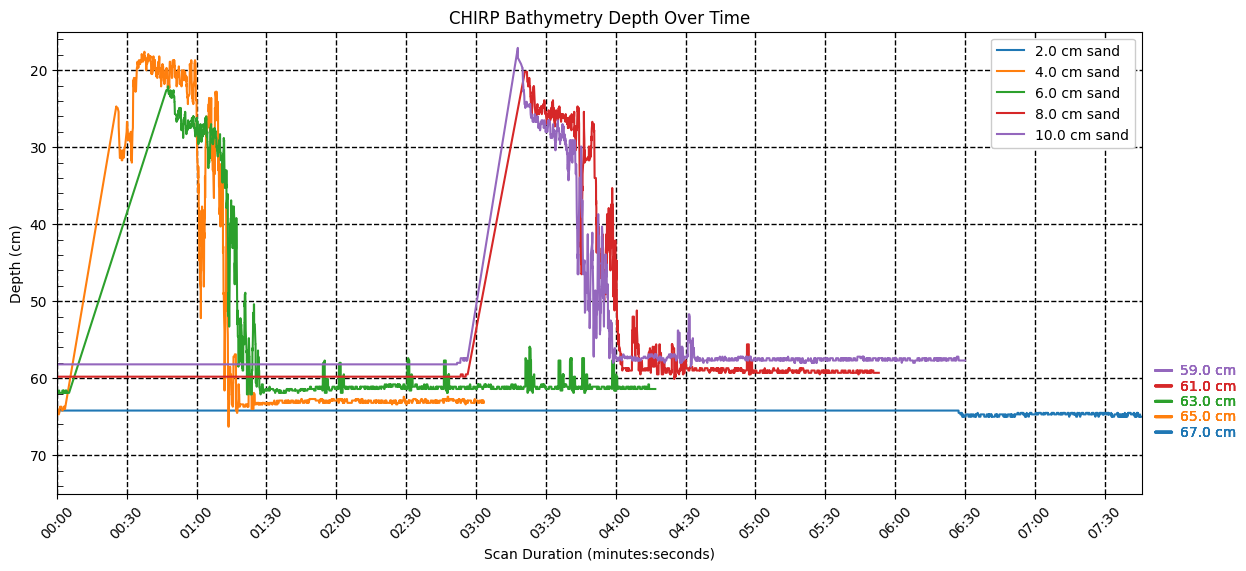

In [70]:
plt.figure(figsize=(14, 6))

for sand_height, depth, timestamp in zip(expected_heights, depths, timestamps):
    ts = [float(t) for t in timestamp if str(t).strip() != ""]
    depth = depth[:len(ts)]

    valid_pairs = [(float(t), d) for t, d in zip(timestamp, depth) if str(t).strip() != ""]
    if not valid_pairs:
        continue

    ts, depth = zip(*valid_pairs)

    initial_time = ts[0]
    scan_relative_times = [(t - initial_time) / 1000 for t in ts]
    depth_cm = [d * 100 for d in depth]

    label = f"{sand_height:.01f} cm sand"
    plt.plot(scan_relative_times, depth_cm, label=label)
    
    ax = plt.gca()
    
    for y_value, color in expected_heights_label:
        ax.annotate(
            "",
            xy=(1.01, y_value),
            xycoords=("axes fraction", "data"),
            xytext=(1.03, y_value),
            textcoords=("axes fraction", "data"),
            arrowprops=dict(arrowstyle="-", color=color, linewidth=2),
        )

        ax.annotate(
            f"{y_value:.1f} cm",
            xy=(1.035, y_value),
            xycoords=("axes fraction", "data"),
            va="center",
            ha="left",
            color=color,
            fontsize=10,
            fontweight="normal",
        )
        
plt.xlabel("Scan Duration (minutes:seconds)")
plt.ylabel("Depth (cm)")
plt.title("CHIRP Bathymetry Depth Over Time")

plt.legend(
frameon=True,
framealpha=1.0,
labelcolor="black",
loc="upper right",
)

ax.xaxis.set_major_locator(MultipleLocator(30))  # every 60 seconds (1 min)
ax.xaxis.set_major_formatter(FuncFormatter(format_time))

ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.tick_params(axis="y", which="minor", length=4, color="black", direction="in")

ax.grid(True, which="major", linestyle="--", linewidth=1, color="black", alpha=1)

ax.margins(x=0)

ax.set_ylim(15, 75)

plt.xticks(rotation=45, color="black")
plt.yticks(color="black")

plt.gca().invert_yaxis()

plt.show()